<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


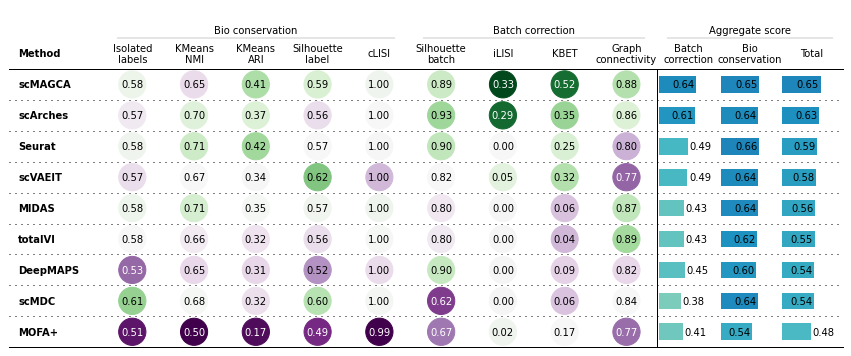

In [1]:
import os
import warnings
from dataclasses import asdict, dataclass
from enum import Enum
from functools import partial
from typing import Any, Callable, Optional, Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import scib_metrics
from scib_metrics.nearest_neighbors import NeighborsResults, pynndescent

Kwargs = dict[str, Any]
MetricType = Union[bool, Kwargs]

_LABELS = "labels"
_BATCH = "batch"
_X_PRE = "X_pre"
_METRIC_TYPE = "Metric Type"
_AGGREGATE_SCORE = "Aggregate score"


def plot_results_table(
    min_max_scale: bool = True, show: bool = True, save_dir: Optional[str] = None
) -> Table:
    """Plot the benchmarking results.

    Parameters
    ----------
    min_max_scale
        Whether to min max scale the results.
    show
        Whether to show the plot.
    save_dir
        The directory to save the plot to. If `None`, the plot is not saved.
    """
    num_embeds = 11
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)
    df = pd.read_csv('../scripts/Fig3/GSE164378_metric.csv', index_col=0)
    # Do not want to plot what kind of metric it is
    plot_df = df.drop(_METRIC_TYPE, axis=0)
    # Sort by total score
    plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)
    plot_df["Method"] = plot_df.index

    # Split columns by metric type, using df as it doesn't have the new method col
    score_cols = df.columns[df.loc[_METRIC_TYPE] == _AGGREGATE_SCORE]
    other_cols = df.columns[df.loc[_METRIC_TYPE] != _AGGREGATE_SCORE]
    column_definitions = [
        ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ]
    # Circles for the metric values
    column_definitions += [
        ColumnDefinition(
            col,
            title=col.replace(" ", "\n", 1),
            width=1,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(plot_df[col]),
            group=df.loc[_METRIC_TYPE, col],
            formatter="{:.2f}",
        )
        for i, col in enumerate(other_cols)
    ]
    # Bars for the aggregate scores
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": matplotlib.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            group=df.loc[_METRIC_TYPE, col],
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(score_cols)
    ]
    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.3 * num_embeds))
        tab = Table(
            plot_df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=plot_df.columns)
    if show:
        plt.show()
    if save_dir is not None:
        fig.savefig(os.path.join(save_dir, "scib_results.svg"), facecolor=ax.get_facecolor(), dpi=300)
    fig.savefig(os.path.join("scib_results.pdf"), facecolor=ax.get_facecolor(), dpi=300)

    return tab


plot_results_table()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import anndata as ad
import mdata
import scanpy as sc

In [ ]:
def plot_bubbles(
    clusters_dict,  
    embedding_key,
    annotation_key,
    colors,
):
    methods = list(embedding_key.keys())


    fig = plt.figure(figsize=(4 * max(len(clusters) for clusters in clusters_dict.values()), 3.5 * len(methods)))
    grid = plt.GridSpec(len(methods), max(len(clusters) for clusters in clusters_dict.values()), figure=fig, wspace=0.4, hspace=0.4)

    axes_dict = {}

    for row_id, method in enumerate(methods):
        clusters = clusters_dict.get(method, [])
        num_clusters = len(clusters)

        axes_row = []
        for i in range(num_clusters):
            ax = fig.add_subplot(grid[row_id, i])
            axes_row.append(ax)
        axes_dict[method] = axes_row

        for i, cluster in enumerate(clusters):
            ax = axes_row[i]

            annot_key = annotation_key[method]

            if cluster not in mdata.obs[annot_key].values:
                print(f"Warning: No cells found for cluster '{cluster}' with value '{cluster}'. Skipping...")
                continue

            idx_cl = mdata.obs[annot_key] == cluster

            if not idx_cl.any():
                print(f"No cells matched for cluster {cluster}.")
                continue

            embedding_pos = ad.AnnData(mdata.obsm[embedding_key[method]].copy())
            embedding_pos.obs_names = mdata.obs_names
            embedding_pos.obs[annot_key] = mdata.obs[annot_key]
            embedding_pos.X[embedding_pos.X < 0] = 0

            embedding_neg = ad.AnnData(-mdata.obsm[embedding_key[method]].copy())
            embedding_neg.obs_names = mdata.obs_names
            embedding_neg.obs[annot_key] = mdata.obs[annot_key]
            embedding_neg.X[embedding_neg.X < 0] = 0

            df = []

            for factor in embedding_pos.var_names:
                embed_ravel = embedding_pos[idx_cl, factor].X.ravel()
                mean_cluster = embed_ravel.mean()
                mean_other = embedding_pos[~idx_cl, factor].X.ravel().mean() if (~idx_cl).any() else np.nan
                prop_expressed = float(np.mean(embed_ravel > 1e-3))
                if prop_expressed > 0:
                    df.append(
                        {
                            "factor": factor,
                            "Sign of weights": "Positive",
                            "mean_cluster": float(mean_cluster),
                            "mean_other": float(mean_other),
                            "Proportion": float(prop_expressed),
                        }
                    )

            for factor in embedding_neg.var_names:
                embed_ravel = embedding_neg[idx_cl, factor].X.ravel()
                mean_cluster = embed_ravel.mean()
                mean_other = embedding_neg[~idx_cl, factor].X.ravel().mean() if (~idx_cl).any() else np.nan
                prop_expressed = float(np.mean(embed_ravel > 1e-3))
                if prop_expressed > 0:
                    df.append(
                        {
                            "factor": factor,
                            "Sign of weights": "Negative",
                            "mean_cluster": float(mean_cluster),
                            "mean_other": float(mean_other),
                            "Proportion": float(prop_expressed),
                        }
                    )

            df = pd.DataFrame(df)

            if not df.empty:  
                max_val = df[["mean_other", "mean_cluster"]].to_numpy().max()
                padding = 0.1 * max_val if not np.isnan(max_val) else 0
                ax.plot(
                    [0, max_val],
                    [0, max_val],
                    linewidth=2,
                    linestyle="--",
                    color="grey",
                )

                sns.scatterplot(
                    data=df,
                    x="mean_other",
                    y="mean_cluster",
                    hue="Sign of weights",
                    palette=colors[method],
                    size="Proportion",
                    ax=ax,
                    sizes=(500 * df["Proportion"].min(), 500 * df["Proportion"].max()),
                    alpha=0.7,
                )

                scores = (df["mean_cluster"] - df["mean_other"]) / df[
                    "mean_cluster"
                ].max() if df["mean_cluster"].max() != 0 else 1
                for j in range(len(df)):
                    score = df["mean_cluster"].iloc[j] - df["mean_other"].iloc[j]
                    score /= df["mean_cluster"].max() if df["mean_cluster"].max() != 0 else 1
                    #if score > 0.25:# 0.15
                    if score in sorted(scores,reverse=True)[:3]:
                        ax.text(
                            df["mean_other"].iloc[j],
                            df["mean_cluster"].iloc[j],
                            df["factor"].iloc[j],
                            horizontalalignment="center",
                            verticalalignment="center",
                            size="small",  
                            color="white",
                            weight="semibold",
                            alpha=0.8,
                        )

                # scores = (df["mean_cluster"] - df["mean_other"]) / df[
                #     "mean_cluster"
                # ].max() if df["mean_cluster"].max() != 0 else 1
                for j, score in enumerate(scores):
                    #if score > 0.2:
                    if score in sorted(scores,reverse=True)[:3]:
                        ax.text(
                            df["mean_other"].iloc[j] + padding,
                            df["mean_cluster"].iloc[j],
                            f"score = {score:.2f}",
                            horizontalalignment="left",
                            verticalalignment="center",
                            size="small",  
                            color="black",
                            weight="semibold",
                            alpha=0.8,
                        )

                ax.set_ylabel("Mean weight in cell type")
                ax.set_xlabel("Mean weight other cell types")

                if i < len(clusters) - 1:
                    ax.get_legend().remove()
                else:
                    ax.legend(
                        loc="upper left",
                        bbox_to_anchor=(1.05, 1),
                        frameon=False,
                        title="Prop. of cells in cluster with\nabsolute weights > 1e-3",
                        fontsize='small'  
                    )

                ax.spines.right.set_visible(False)
                ax.spines.top.set_visible(False)
                ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
                ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
                ax.set_xlim(-padding, max_val + padding if not np.isnan(max_val) else 0)
                ax.set_ylim(-padding, max_val + padding if not np.isnan(max_val) else 0)


            ax.set_title(cluster, fontsize=10)  

        for empty_idx in range(len(clusters), len(axes_row)):
            fig.delaxes(axes_row[empty_idx])

    plt.savefig('../scripts/GSE164378/factor_GSE164378.pdf', bbox_inches="tight")

/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palett

/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_2405683/2112905610.py:99: UserWarning: 
The palett

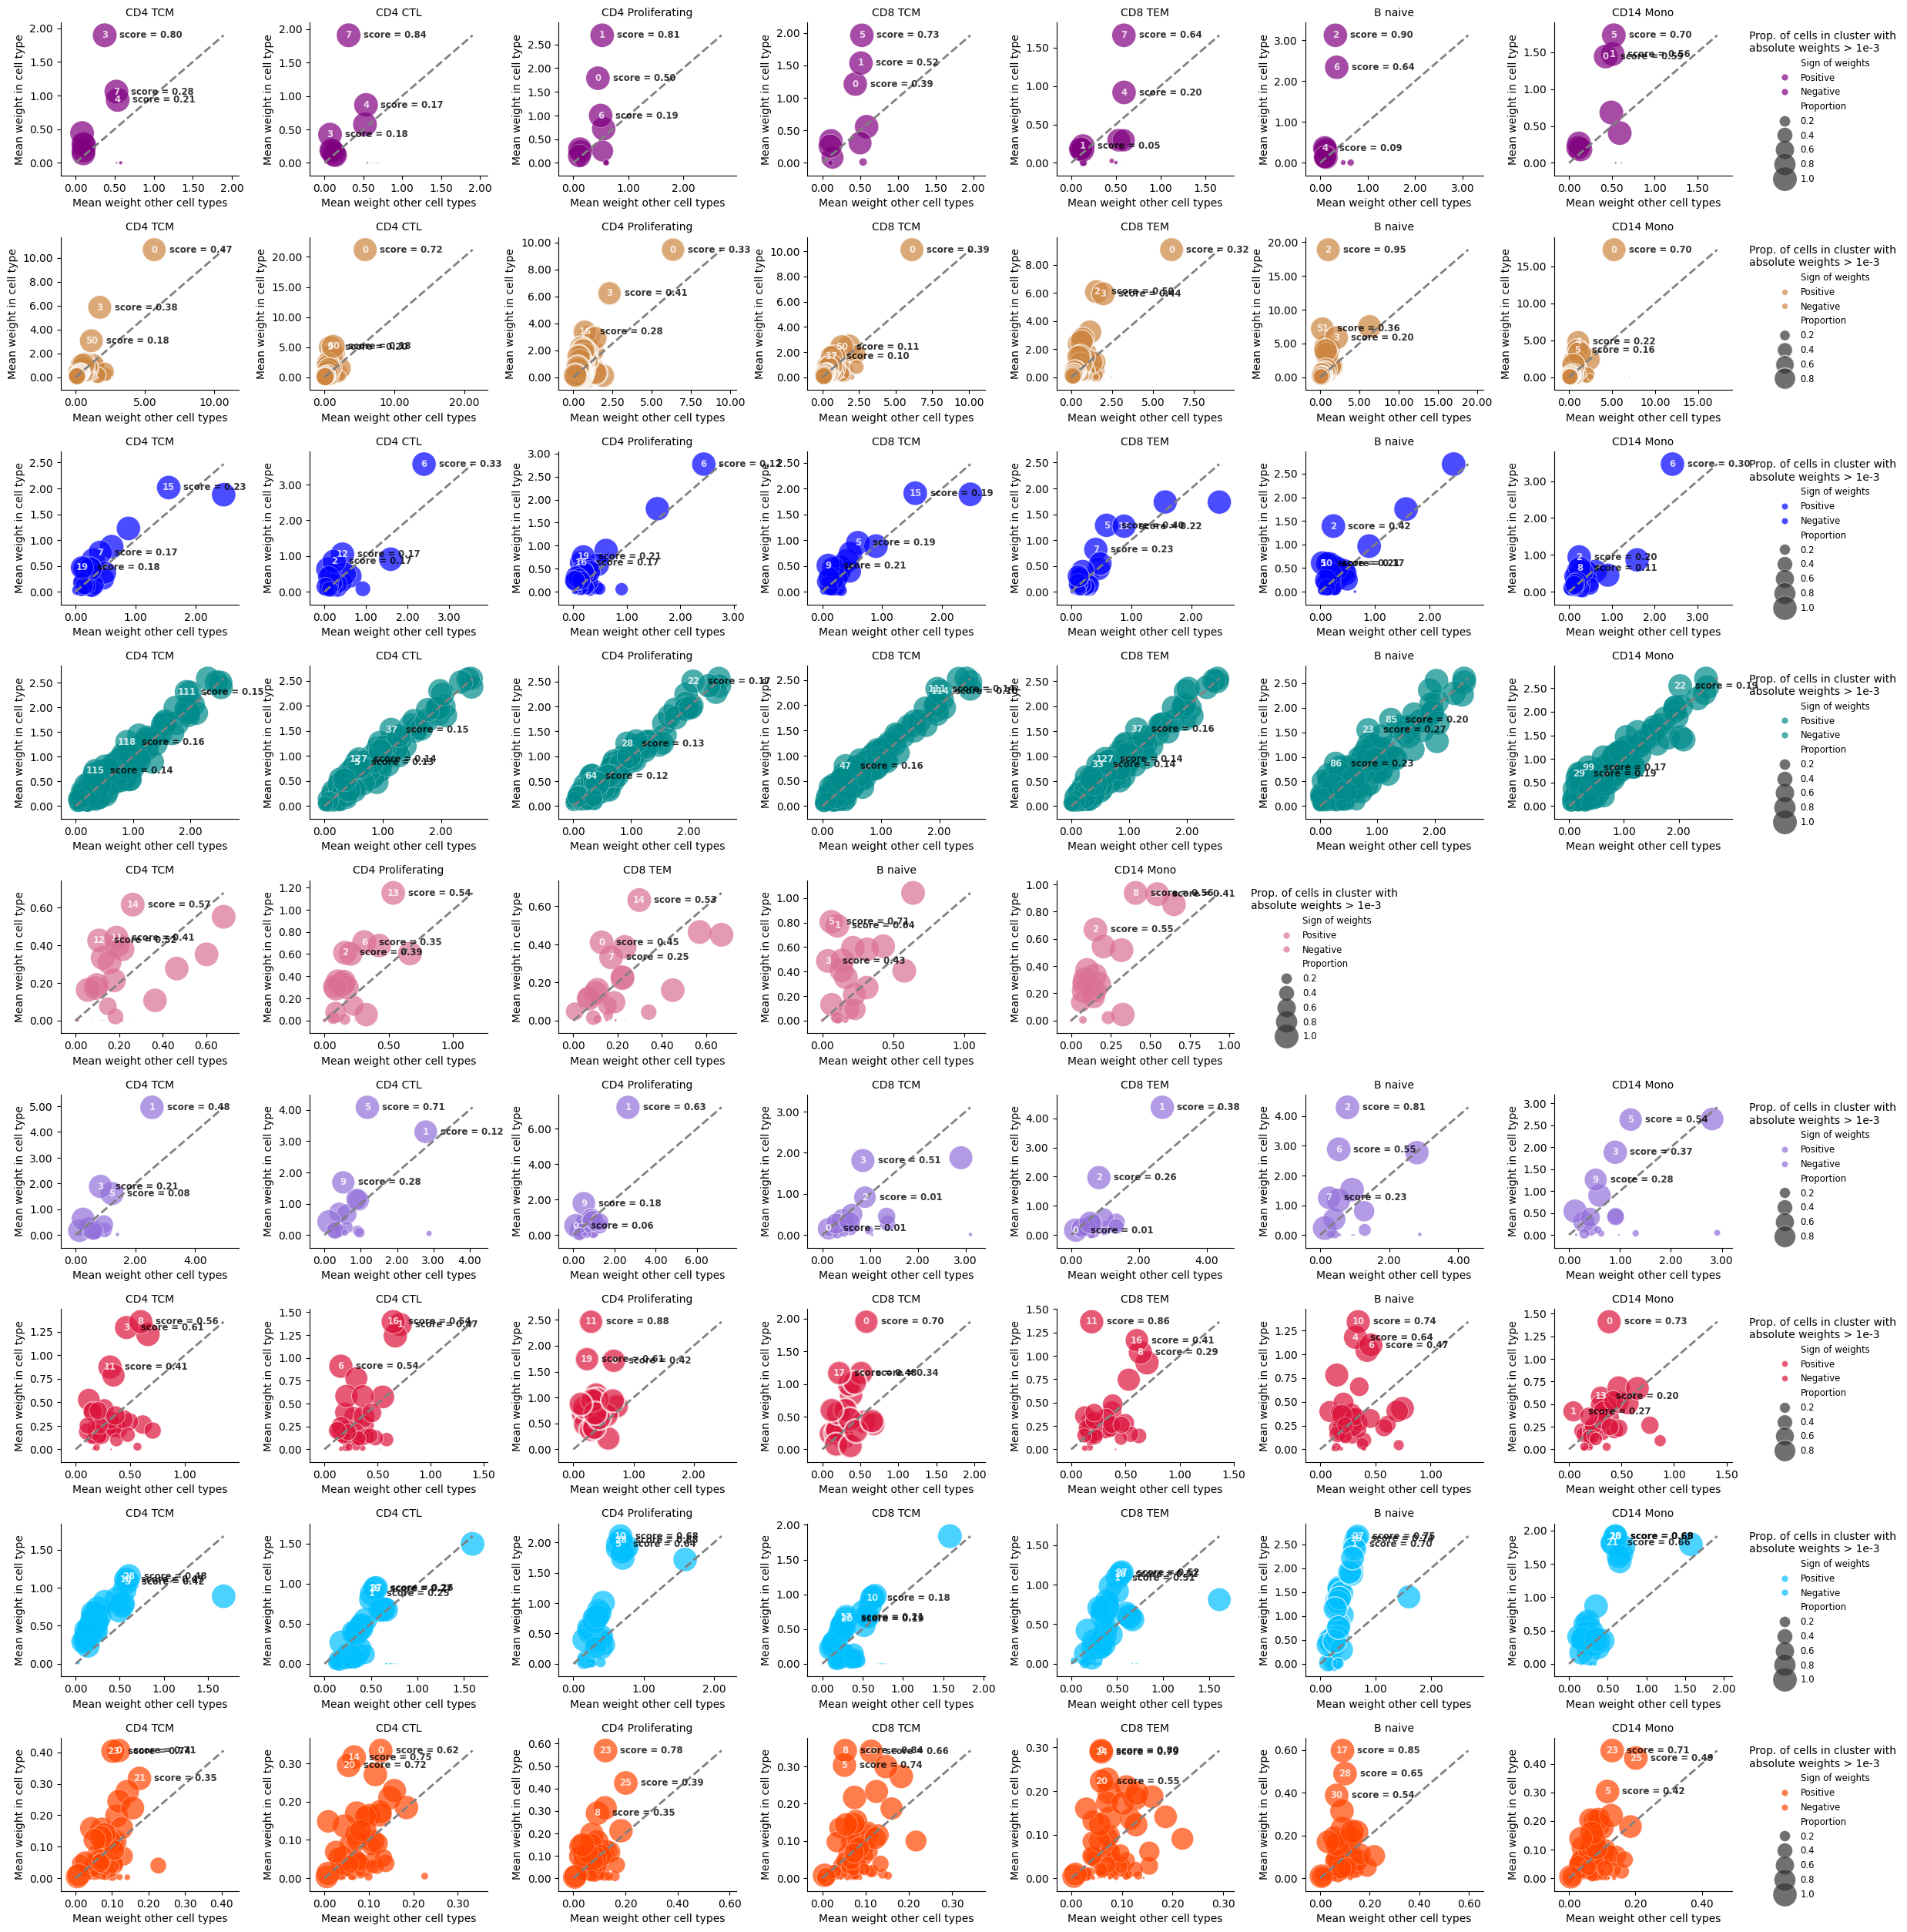

In [ ]:
x = np.array(sc.read_h5ad('../datasets/GSE164378/GSE164378_rna.h5ad').to_df()).astype('float32')
feature = sc.read_h5ad('../datasets/GSE164378/GSE164378_rna.h5ad').var['features'].index
mdata = sc.AnnData(x)
mdata.var['genes'] = feature

mdata.obsm["X_scMAGCA"] = np.array(pd.read_csv('../scripts/GSE164378/scMAGCA_embedding.csv',header=None))
mdata.obsm["X_Seurat"] = np.array(pd.read_csv('../scripts/GSE164378/Seurat_embedding.csv',header=None))
mdata.obsm["X_totalVI"] = np.array(pd.read_csv('../scripts/GSE164378/totalVI_embedding.csv',header=None))
mdata.obsm["X_DeepMAPS"] = np.array(pd.read_csv('../scripts/GSE164378/DeepMAPS_embedding.csv',header=None))
mdata.obsm["X_scMDC"] = np.array(pd.read_csv('../scripts/GSE164378/scMDC_embedding.csv',header=None))
mdata.obsm["X_MOFA+"] = np.array(pd.read_csv('../scripts/GSE164378/MOFA+_embedding.csv',header=None))
mdata.obsm["X_scArches"] = np.array(pd.read_csv('../scripts/GSE164378/scArches_embedding.csv', header=None))
mdata.obsm["X_scVAEIT"] = np.array(pd.read_csv('../scripts/GSE164378/scVAEIT_embedding.csv', header=None))
mdata.obsm["X_MIDAS"] = np.load('../scripts/GSE164378/MIDAS_embedding.npy')

mdata.obs["annotation_scMAGCA"] = np.array(pd.read_csv('../scripts/GSE164378/scMAGCA_name.csv',header=None))
mdata.obs["annotation_Seurat"] = np.array(pd.read_csv('../scripts/GSE164378/Seurat_name.csv',header=None))
mdata.obs["annotation_totalVI"] = np.array(pd.read_csv('../scripts/GSE164378/totalVI_name.csv',header=None))
mdata.obs["annotation_DeepMAPS"] = np.array(pd.read_csv('../scripts/GSE164378/DeepMAPS_name.csv',header=None))
mdata.obs["annotation_scMDC"] = np.array(pd.read_csv('../scripts/GSE164378/scMDC_name.csv',header=None))
mdata.obs["annotation_MOFA+"] = np.array(pd.read_csv('../scripts/GSE164378/MOFA+_name.csv',header=None))
mdata.obs["annotation_scArches"] = np.array(pd.read_csv('../scripts/GSE164378/scArches_name.csv',header=None))
mdata.obs["annotation_scVAEIT"] = np.array(pd.read_csv('../scripts/GSE164378/scVAEIT_name.csv',header=None))
mdata.obs["annotation_MIDAS"] = np.array(pd.read_csv('../scripts/GSE164378/MIDAS_name.txt',header=None))

clusters_dict = {
    "scMAGCA": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"],
    "Seurat": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"],
    "totalVI": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"],
    "DeepMAPS": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"],
    "scMDC": ["CD4 TCM","CD4 Proliferating",
                "CD8 TEM",
                "B naive","CD14 Mono"],
    "MOFA+": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"],
    "scArches": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"],
    "scVAEIT": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"],
    "MIDAS": ["CD4 TCM","CD4 CTL","CD4 Proliferating",
                "CD8 TCM","CD8 TEM",
                "B naive","CD14 Mono"]
}


plot_bubbles(
    clusters_dict=clusters_dict,
    embedding_key={
        "scMAGCA":"X_scMAGCA",
        "Seurat":"X_Seurat",
        "totalVI":"X_totalVI",
        "DeepMAPS":"X_DeepMAPS",
        "scMDC":"X_scMDC",
        "MOFA+":"X_MOFA+",
        "scArches":"X_scArches",
        "scVAEIT":"X_scVAEIT",
        "MIDAS":"X_MIDAS"
    },
    annotation_key={
        "scMAGCA": "annotation_scMAGCA",
        "Seurat": "annotation_Seurat",
        "totalVI": "annotation_totalVI",
        "DeepMAPS": "annotation_DeepMAPS",
        "scMDC": "annotation_scMDC",
        "MOFA+": "annotation_MOFA+",
        "scArches": "annotation_scArches",
        "scVAEIT": "annotation_scVAEIT",
        "MIDAS": "annotation_MIDAS"
    },
    colors={
        "scMAGCA": ["purple"],
        "Seurat": ["peru"],
        "totalVI": ["blue"],
        "DeepMAPS": ["Darkcyan"],
        "scMDC": ["Palevioletred"],
        "MOFA+": ["mediumpurple"],
        "scArches": ["crimson"],
        "scVAEIT": ["deepskyblue"],
        "MIDAS": ["orangered"]
    }
)

In [5]:
import numpy as np
import pandas as pd
import mdata
import scipy.stats
import numpy as np
import pandas as pd
import scanpy as sc

In [7]:
def analyze_factor_genes(adata, factor_index=3):

    weights = adata.obsm["X_scMAGCA"][:, factor_index]
    adata.obs['cell_type'] = adata.obs['annotation_scMAGCA']
    
    non_zero_genes = []
    for i in range(adata.n_vars):
        gene_expr = adata.X[:, i].ravel()
        if np.var(gene_expr) > 1e-6:  
            non_zero_genes.append(i)
    
    cell_types = ["CD4 TCM"]
    results = {}
    
    for ct in cell_types:
        ct_idx = adata.obs['cell_type'] == ct
        ct_weights = weights[ct_idx]
        ct_data = adata[ct_idx]
        
        ct_correlations = []
        for i in non_zero_genes:
            gene_expr = ct_data.X[:, i].ravel()
            gene_name = ct_data.var['genes'][i]
            
            if np.var(gene_expr) < 1e-6 or np.var(ct_weights) < 1e-6:
                continue
                
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=scipy.stats.ConstantInputWarning)
                corr, pval = scipy.stats.spearmanr(ct_weights, gene_expr, nan_policy='omit')
            
            ct_correlations.append({
                "gene": gene_name,
                "correlation": corr,
                "p_value": pval
            })
        
        ct_df = pd.DataFrame(ct_correlations)
        ct_df = ct_df.sort_values("correlation", ascending=False)
        results[ct] = ct_df

    for ct in results:
        results[ct].to_csv(f"factor3_{ct}_correlations.csv", index=False)
        results[ct].iloc[:100,:].to_csv(f"factor3_{ct}_correlations_top100.csv", index=False)

    return results[ct].iloc[:100,:]

In [8]:
x = np.array(sc.read_h5ad('../datasets/GSE164378/GSE164378_rna.h5ad').to_df()).astype('float32')
feature = sc.read_h5ad('../datasets/GSE164378/GSE164378_rna.h5ad').var['features'].index
mdata = sc.AnnData(x)
mdata.var['genes'] = feature

mdata.obsm["X_scMAGCA"] = np.array(pd.read_csv('../scripts/GSE164378/scMAGCA_embedding.csv',header=None))
mdata.obs["annotation_scMAGCA"] = np.array(pd.read_csv('../scripts/GSE164378/scMAGCA_name.csv',header=None))

import warnings
warnings.filterwarnings("ignore", category=scipy.stats.ConstantInputWarning)

cell_type_results = analyze_factor_genes(mdata)

In [11]:
cell_type_results[:15]

,gene,correlation,p_value
2888,MAL,0.100909,2.221333e-52
12840,ITGB1,0.080709,4.472506e-34
9891,NEFL,0.075866,2.702171e-30
3381,SLC40A1,0.070503,2.226814e-26
10013,AP3M2,0.067474,2.709553e-24
20690,JUNB,0.056360,2.039095e-17
2277,TPO,0.054646,1.826301e-16
19576,BCL2,0.053966,4.281654e-16
19404,TTC39C-AS1,0.053017,1.380942e-15
12757,VIM,0.049162,1.304357e-13


In [17]:
cell_type_results['gene'][:15]

2888            MAL
12840         ITGB1
9891           NEFL
3381        SLC40A1
10013         AP3M2
20690          JUNB
2277            TPO
19576          BCL2
19404    TTC39C-AS1
12757           VIM
12440    AP002884.1
7308           PI16
9226          TIMP1
5619         INPP4B
5924           IL7R
Name: gene, dtype: object

In [24]:
cell_type_results.loc[:,['gene','p_value']][:15]

,gene,p_value
2888,MAL,2.221333e-52
12840,ITGB1,4.472506e-34
9891,NEFL,2.702171e-30
3381,SLC40A1,2.226814e-26
10013,AP3M2,2.709553e-24
20690,JUNB,2.039095e-17
2277,TPO,1.826301e-16
19576,BCL2,4.281654e-16
19404,TTC39C-AS1,1.380942e-15
12757,VIM,1.304357e-13


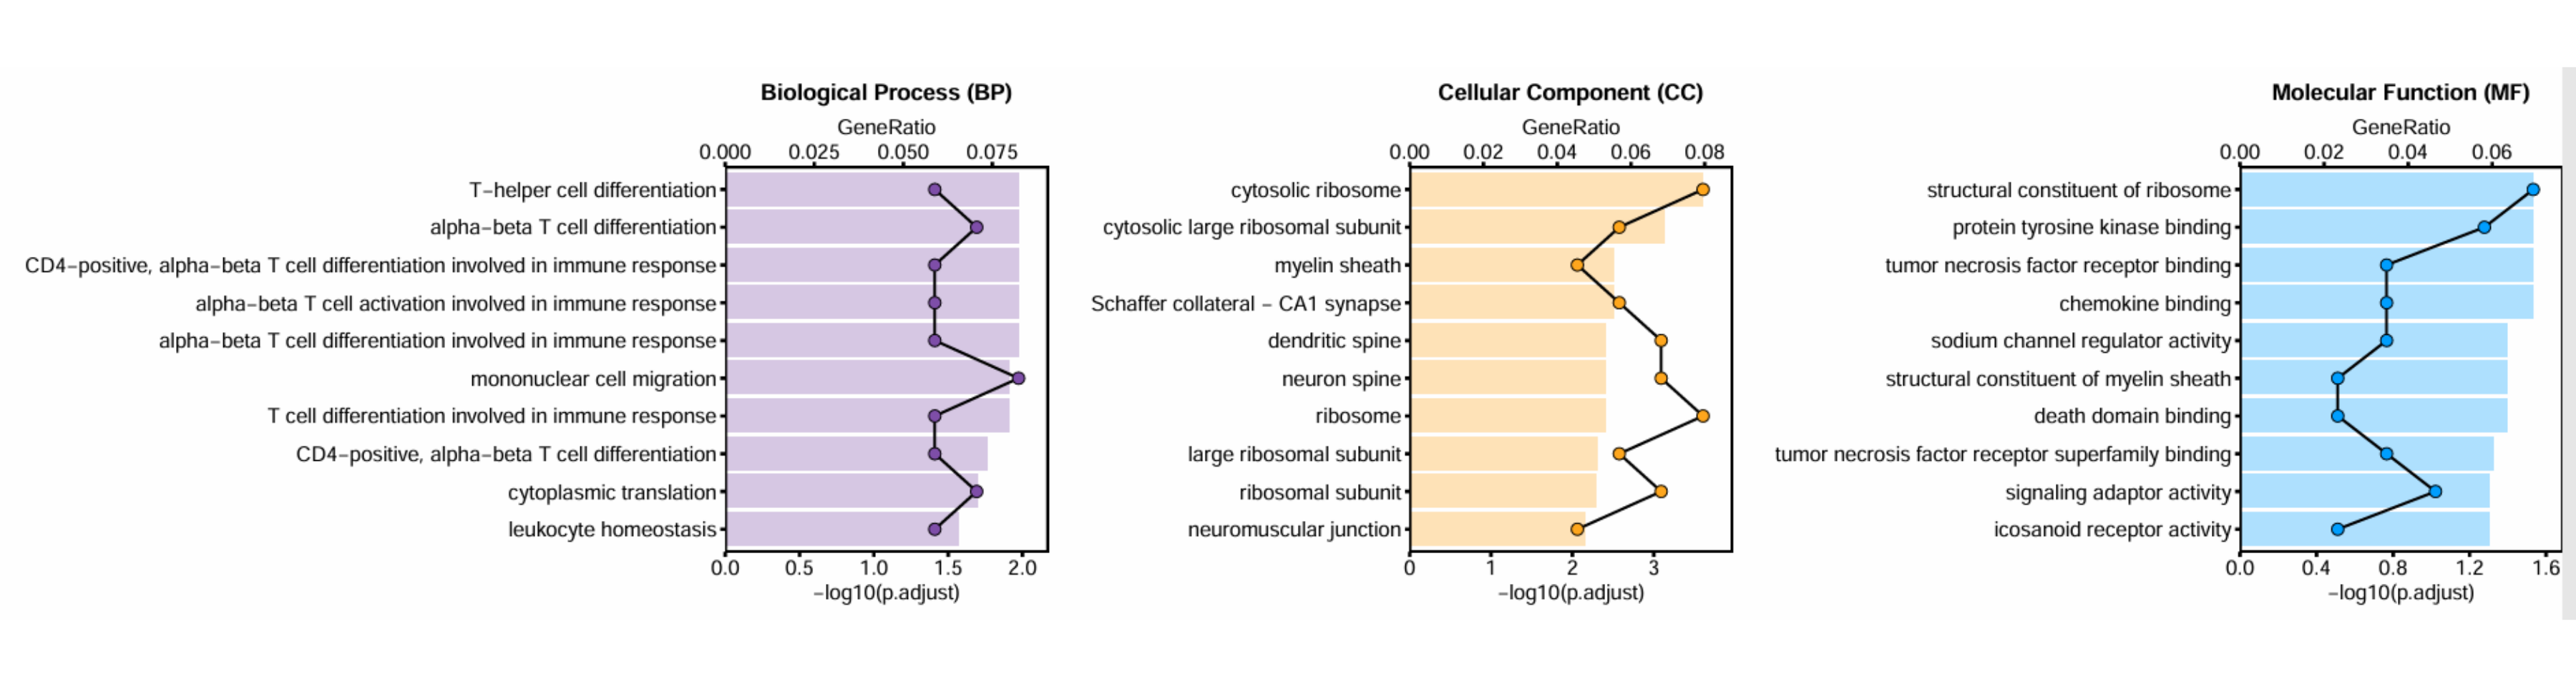

In [25]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(tidyverse)
library(patchwork)

genes <- c('MAL', 'ITGB1', 'NEFL', 'SLC40A1', 'AP3M2', 'JUNB', 'TPO', 'BCL2',
           'TTC39C-AS1', 'VIM', 'AP002884.1', 'PI16', 'TIMP1', 'INPP4B', 'IL7R',
           'DST', 'SOCS3', 'EDA', 'MCOLN3', 'GREM2', 'GPR183', 'LPAR6', 'RPL36A',
           'CXCR4', 'TOB1', 'PLP2', 'RPL39', 'TNFRSF4', 'WNT7A', 'FRY', 'MDFIC',
           'EPHA1-AS1', 'CFH', 'FXYD7', 'PTGER2', 'USP10', 'AQP3', 'TRABD2A',
           'PASK', 'FBLN5', 'TRIM2', 'RIPK2', 'ALOX5', 'AC009041.1', 'SH3BP5',
           'ADAM23', 'BCL9', 'SNHG18', 'TRAT1', 'RNF157', 'AC009041.2', 'RPL36',
           'CITED4', 'SOCS2', 'ANXA1', 'ANKRD18A', 'SH2D4A', 'LINC02273',
           'AC005842.1', 'GCSAM', 'FXYD1', 'MAP3K1', 'NECTIN3', 'CSGALNACT1',
           'RGCC', 'APP', 'FRY-AS1', 'AL121748.1', 'TMEM45B', 'RPL38', 'TRADD',
           'BIRC3', 'LTB', 'ACVR1C', 'FXYD5', 'RPS26', 'RPL14', 'EPHA4', 'RCBTB2',
           'TCEA3', 'PATJ', 'VIPR1', 'SERINC5', 'COL27A1', 'SELENOM', 'CD69',
           'PTPRO', 'CYSLTR2', 'ARHGAP32', 'AC058791.1', 'CEP112', 'GABBR1',
           'USP46', 'SASH1', 'THOC3', 'AK5', 'FAM241A', 'PLEKHB1', 'TSPAN18','CMTM8')

GO_database <- "org.Hs.eg.db"

gene <- bitr(
  genes,
  fromType = "SYMBOL",
  toType   = "ENTREZID",
  OrgDb    = GO_database
)

go <- enrichGO(
  gene          = gene$ENTREZID,
  OrgDb         = GO_database,
  keyType       = "ENTREZID",
  ont           = "ALL",
  pvalueCutoff  = 0.05,
  qvalueCutoff  = 0.05,
  readable      = TRUE
)

goresult <- as.data.frame(go@result)
goresult$GeneRatio <- sapply(
  strsplit(as.character(goresult$GeneRatio), "/"),
  function(x) as.numeric(x[1]) / as.numeric(x[2])
)

plot_go_panel <- function(goresult, class, color, main_title) {
  
  go_select <- goresult %>%
    filter(ONTOLOGY == class, pvalue < 0.05) %>% 
    arrange(pvalue) %>%                           
    head(10) %>%
    mutate(
      Description = factor(Description, levels = rev(unique(Description))),
      padj_log    = -log10(p.adjust)             
    )
  
  if (nrow(go_select) == 0) {
    stop(paste("No enriched terms for", class))
  }
  
  scale_factor <- max(go_select$padj_log, na.rm = TRUE) /
    max(go_select$GeneRatio, na.rm = TRUE)
  
  ggplot(go_select, aes(y = reorder(Description, padj_log))) +
    geom_bar(
      aes(x = padj_log),
      stat = "identity",
      fill = paste0(color, "50")
    ) +
    geom_path(
      aes(x = GeneRatio * scale_factor,
          y = reorder(Description, padj_log),
          group = 1),
      color = "black",
      linewidth = 0.75
    ) +
    geom_point(
      aes(x = GeneRatio * scale_factor),
      shape = 21,
      fill  = color,
      color = "black",
      size  = 3
    ) +
    scale_x_continuous(
      name    = "-log10(p.adjust)",
      sec.axis = sec_axis(~ . / scale_factor, name = "GeneRatio"),
      expand  = expansion(mult = c(0, 0.1))
    ) +
    labs(
      title = main_title,
      y     = ""
    ) +
    theme_minimal() +
    theme(
      panel.background = element_rect(fill = NA, color = NA),
      panel.grid       = element_blank(),
      panel.border     = element_rect(colour = "black", fill = NA, linewidth = 1),
      axis.text        = element_text(color = "black", size = 12),
      axis.title       = element_text(size  = 12),
      axis.ticks       = element_line(colour = "black", linewidth = 1),
      plot.title       = element_text(hjust = 0.5, face = "bold")
    )
}

p_bp <- plot_go_panel(goresult, "BP", "#7f4ea8", "Biological Process (BP)")
p_cc <- plot_go_panel(goresult, "CC", "#ffa61d", "Cellular Component (CC)")
p_mf <- plot_go_panel(goresult, "MF", "#009eff", "Molecular Function (MF)")

final_plot <- p_bp + p_cc + p_mf + plot_layout(nrow = 1)
final_plot

ggsave(
  filename = "GSE164378_factor3_all.pdf",
  plot     = final_plot,
  width    = 21,
  height   = 4.5
)

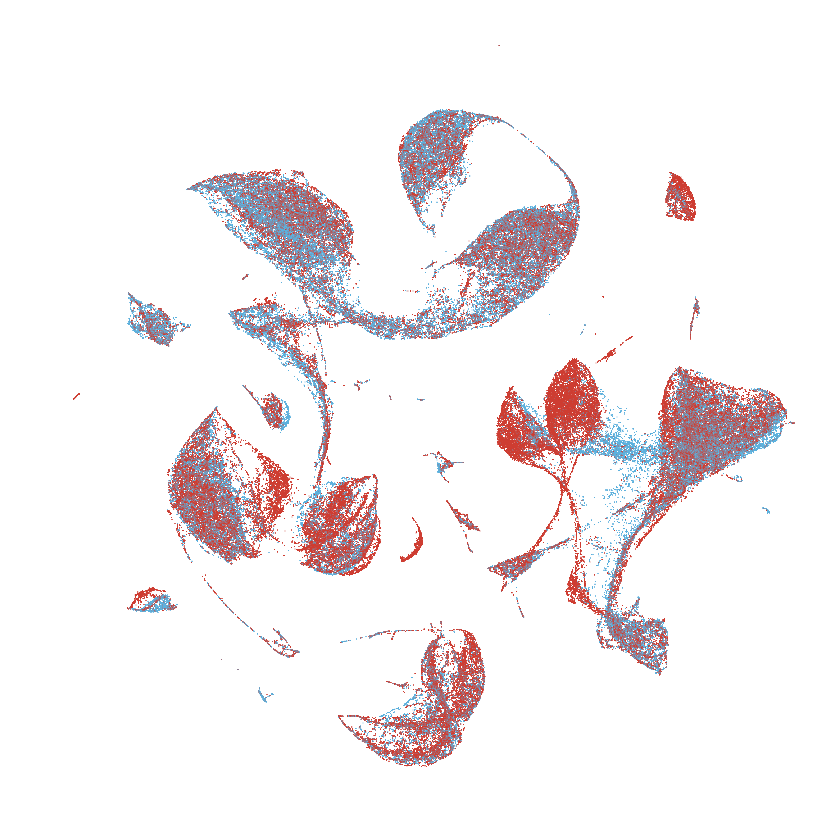

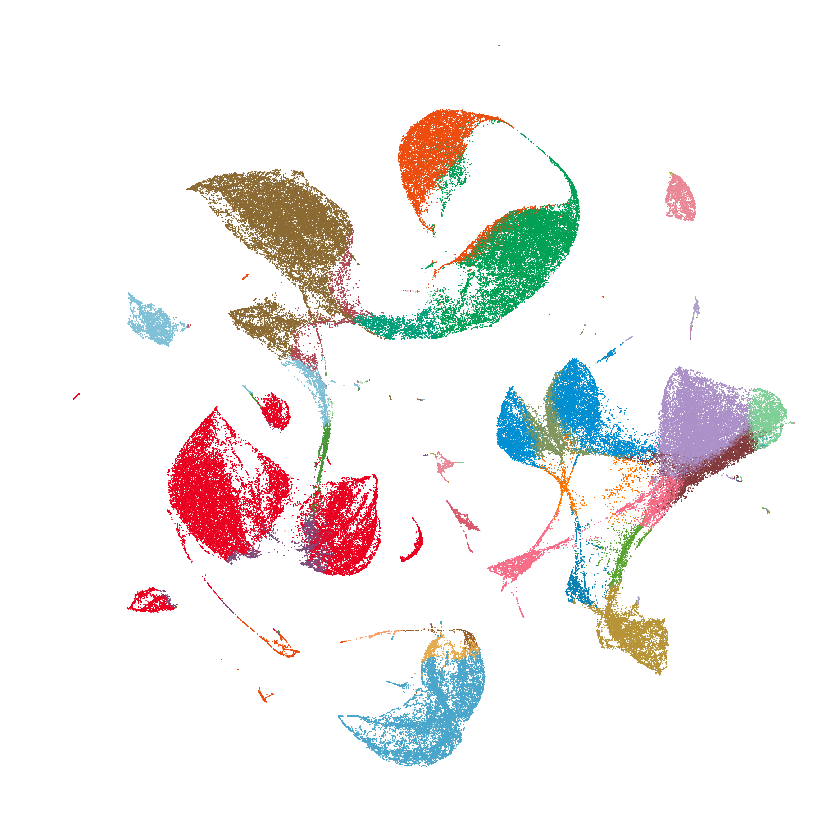

In [7]:
library(umap)
library(ggplot2)
library(scattermore)
library(reticulate)
use_condaenv("/home/zhouzeming/anaconda3", required = TRUE)
set.seed(64)
z <- read.csv(file = "../scripts/GSE164378/scMAGCA_embedding.csv", sep = ",", header = FALSE)
# z.umap<-umap(z)
z.umap<-umap(z,method="umap-learn")

label1 <- read.csv(file = "../datasets/GSE164378/GSE164378_batch.csv", sep = ",", header = FALSE)
label1$V1 <- as.factor(label1$V1)  
bm_table_num <- data.frame(UMAP1=z.umap$layout[,1], UMAP2=z.umap$layout[,2],Cluster = label1$V1)

ggplot()+
  geom_scattermore(aes(z.umap$layout[,1],z.umap$layout[,2],color = label1$V1),
                   pointsize=3,pixels = c(3000,3000))+
  theme_bw(base_line_size = 1,base_rect_size = 1) +
  scale_color_manual(values = c("1"="#5DB1DDFF","2"="#CE3D32FF"))+
  labs(x = "", y = "", color = "Label")+  # Set x and y axis labels
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, face = 'bold'),  # Set title to center
    axis.ticks.length=unit(0, "lines"),  # Remove axis ticks but keep axis labels
    axis.text = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = NA),
    axis.title.x = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    axis.title.y = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 8),
    panel.border = element_blank(),
    legend.position = "none")+
  guides(color = guide_legend(override.aes = list(size = 3), nrow=7))


label2 <- read.csv(file = "../scripts/GSE164378/scMAGCA_name.csv", sep = ",", header = FALSE)
label2$V1 <- as.factor(label2$V1)  
bm_table_num <- data.frame(UMAP1=z.umap$layout[,1], UMAP2=z.umap$layout[,2],Cluster = label2$V1)
ggplot()+
  geom_scattermore(aes(z.umap$layout[,1],z.umap$layout[,2],color = label2$V1),
                   pointsize=3,pixels = c(3000,3000))+
  theme_bw(base_line_size = 1,base_rect_size = 1) +
  scale_color_manual(values = c("CD14 Mono"="#833a3c","CD4 TCM"="#8b6a33","CD8 Naive"="#ed4d0f","NK"="#0881b4","CD8 TEM"="#489835","CD16 Mono"="#b89439","B intermediate"="#e4ab4f",
                                         "CD4 Naive"="#00a155","CD4 CTL"="#ea0020","B naive"="#4aa6cb","MAIT"="#80c1d7","gdT"="#af4852","CD8 TCM"="#7fd097","dnT"="#b0deb7",
                                         "B memory"="#975e26","Doublet"="#b7b03f","pDC"="#d95b6c","CD8 Proliferating"="#ff7400","Treg"="#009e79","Plasmablast"="#ff9e65","CD4 TEM"="#59a331",
                                         "cDC2"="#f86e89","NK Proliferating"="#ed4d0f","ASDC"="#e98996","HSPC"="#ed4d0f","Platelet"="#e98996","NK_CD56bright"="#7f4e7c","CD4 Proliferating"="#b1a1cc",
                                         "Eryth"="#82975f","cDC1"="#008fd2","ILC"="#ac91c9"))+
  labs(x = "", y = "", color = "Label")+  # Set x and y axis labels
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, face = 'bold'),  # Set title to center
    axis.ticks.length=unit(0, "lines"),  # Remove axis ticks but keep axis labels
    axis.text = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = NA),
    axis.title.x = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    axis.title.y = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 8),
    panel.border = element_blank(),
    legend.position = "none")+
  guides(color = guide_legend(override.aes = list(size = 3), nrow=7))
